# Notebook 2 — From DE results to biology

In this continuation, we start from the DESeq2 results created in the first notebook.

**Goal for this part**
- Focus on **significant** and **biologically meaningful** genes (e.g. `padj < 0.05` and `|log2FC| ≥ 1`).
- Explore patterns across samples using **variance-stabilized** values (rlog/vst).
- Prepare inputs for **clustering** and **enrichment** analyses.

**What you’ll do:** turn the differential expression (DE) table from Notebook 1 into **patterns and biology** you can explain.

**Today’s focus**
- Visualize **top DE genes** with a small heatmap (rlog values).
- Group DE genes into **clusters** (WGCNA example) to reveal gene programs.
- Export **gene lists** (already implemented) and use **Enrichr** *outside* the notebook.
- Prepare a short **biological interpretation** to present.



In [1]:
suppressMessages(library(DESeq2)) # load the DESeq2 package
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)
# Nicer default text size for ggplot objects (affects plotPCA etc.)
if (requireNamespace("ggplot2", quietly = TRUE)) {
  ggplot2::theme_set(ggplot2::theme_minimal(base_size = 14))
}

In [2]:
counts <- read.delim("data/counts.txt", sep="\t", check.names=FALSE, as.is=TRUE)

In [3]:
sample.info <- read.delim("data/sample_info.txt", sep="\t", check.names=FALSE)

In [4]:
model <- read.delim("data//diffexpr-results.csv", sep="\t", check.names=FALSE, row.names = 1)

In [5]:
head(model)

,gene_name,gene_biotype,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000091972,CD200,protein_coding,308.88085,3.655553,0.2549300,14.24828,4.594363e-46,8.261124e-42
ENSG00000187601,MAGEH1,protein_coding,502.70770,3.161109,0.2713223,11.62718,2.998268e-31,2.695593e-27
ENSG00000235304,LINC01281,lincRNA,82.04318,4.885560,0.3725924,11.40384,4.000574e-30,2.397811e-26
ENSG00000125538,IL1B,protein_coding,1089.90272,-1.868678,0.1713133,-10.90576,1.081822e-27,4.863061e-24
ENSG00000003147,ICA1,protein_coding,449.93853,3.382408,0.3211463,10.50646,8.066292e-26,2.900800e-22
ENSG00000149257,SERPINH1,protein_coding,1233.86635,3.537199,0.3401289,10.40158,2.438441e-25,7.307600e-22


## Subset to significant genes and transform counts

We filter the results to genes that pass **both** thresholds:
- **Significance:** `padj < 0.05`
- **Effect size:** `|log2FoldChange| ≥ 1`

Then we transform counts for visualization:
- Use **rlog** (or **vst**) to put expression on a scale suitable for clustering/plots.
- These transformed values make differences more comparable across samples.

> Remember: rlog/vst stabilize the variance but do **not** change the statistical testing you already did.


In [6]:
counts <- counts[rownames(model),]

In [7]:
de <- DESeqDataSetFromMatrix(as.matrix(round(counts)), colData = sample.info, design=~Sample_Group)

converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


In [8]:
dat <- rlog(de, blind=FALSE)

## Inspect patterns: heatmap and sample grouping

A heatmap of the top differentially expressed genes helps answer:
- Do samples separate by **Sample_Group** as expected?
- Are there **blocks** of co-expressed genes?
- Any **outlier samples** that need attention?

We will annotate columns by `Sample_Group` to make interpretation straightforward.


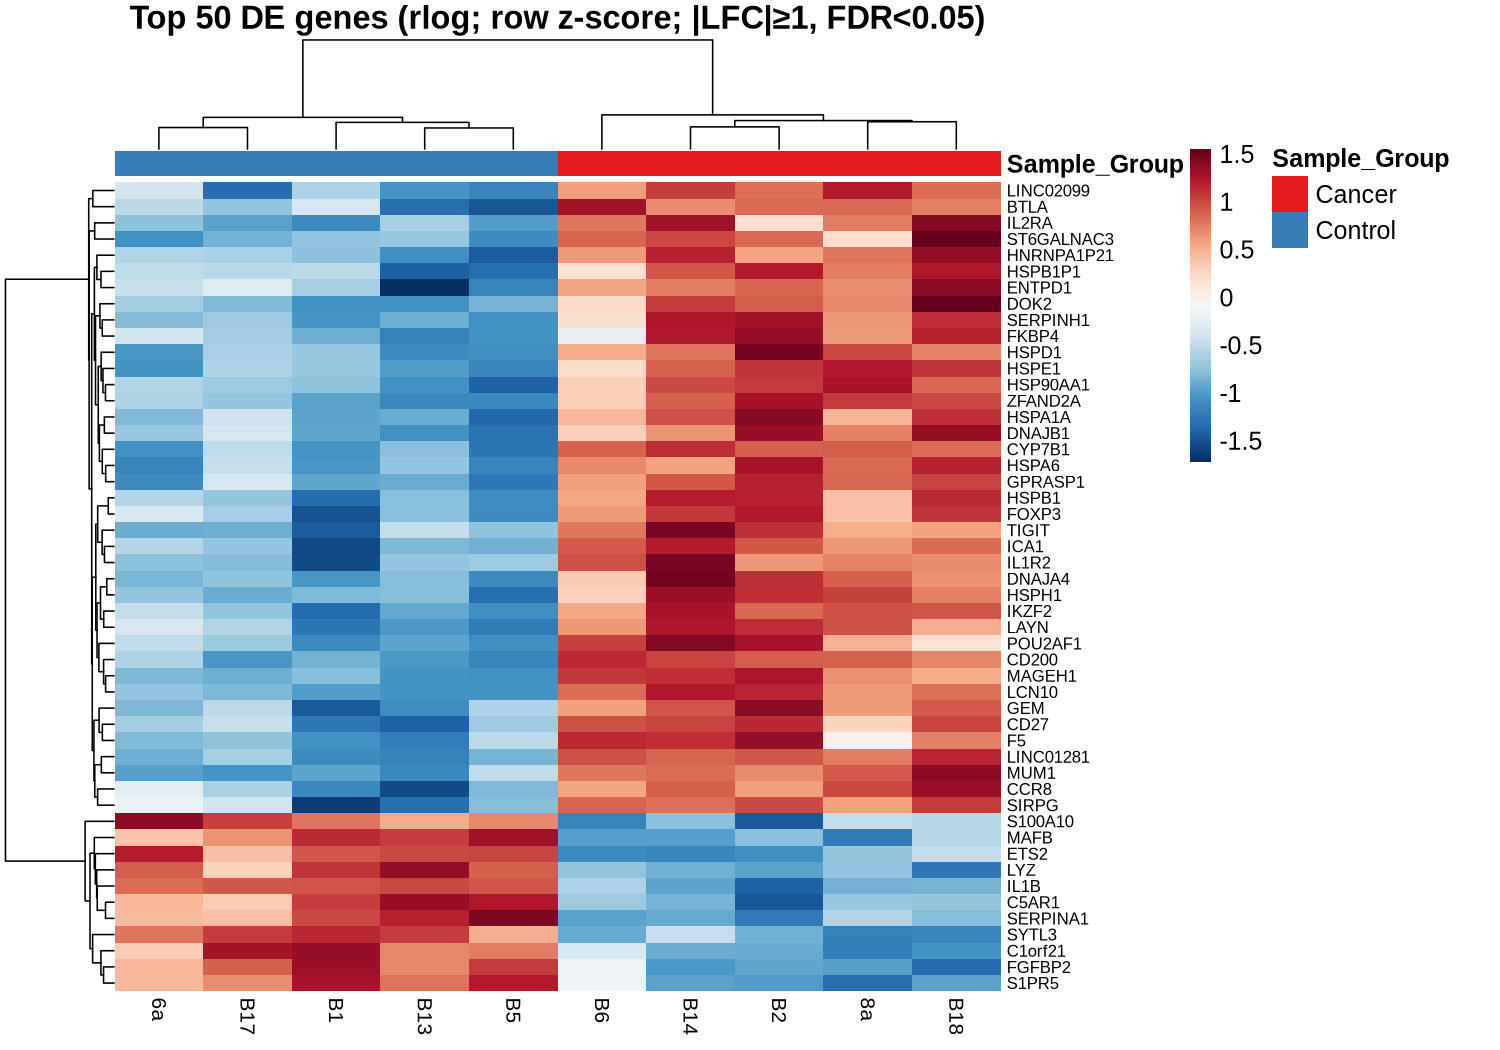

In [9]:
# Make figures readable in Jupyter
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 150)

library(pheatmap)
library(RColorBrewer)
# If SummarizedExperiment not attached: we'll use it below for rowData()
# library(SummarizedExperiment)

# thresholds and size
lfc_cutoff <- 1
fdr_cutoff <- 0.05
topN <- 50

stopifnot(all(c("log2FoldChange","padj") %in% colnames(model)))

# 1) choose genes (prefer both FDR & |LFC|; else fallback to top by FDR)
sig_idx  <- which(!is.na(model$padj) &
                  model$padj < fdr_cutoff &
                  abs(model$log2FoldChange) >= lfc_cutoff)
gene_ids <- rownames(model)[sig_idx]
gene_ids <- intersect(gene_ids, rownames(assay(dat)))

if (length(gene_ids) == 0L) {
  ok  <- which(!is.na(model$padj))
  ord <- order(model$padj[ok])
  gene_ids <- rownames(model)[ok][ord]
  gene_ids <- intersect(gene_ids, rownames(assay(dat)))
  gene_ids <- head(gene_ids, topN)
} else {
  gene_ids <- head(gene_ids[order(model[gene_ids, "padj"])], topN)
}

# 2) rlog matrix and row z-score
mat   <- assay(dat)[gene_ids, , drop = FALSE]
mat_z <- t(scale(t(mat)))
mat_z[!is.finite(mat_z)] <- 0

# 3) build gene symbols for row names
get_symbols_from_model <- function(ids) {
  if ("gene_name" %in% colnames(model)) {
    out <- model[ids, "gene_name"]
    names(out) <- ids
    as.character(out)
  } else NULL
}
get_symbols_from_rowdata <- function(ids) {
  rd <- as.data.frame(SummarizedExperiment::rowData(dat))
  if (!is.null(rd) && "gene_name" %in% colnames(rd)) {
    out <- rd[ids, "gene_name"]
    names(out) <- ids
    as.character(out)
  } else NULL
}

gene_symbols <- get_symbols_from_model(gene_ids)
if (is.null(gene_symbols)) gene_symbols <- get_symbols_from_rowdata(gene_ids)

# fallback to IDs if missing/empty, and ensure uniqueness
if (is.null(gene_symbols)) gene_symbols <- gene_ids
bad <- is.na(gene_symbols) | gene_symbols == ""
gene_symbols[bad] <- gene_ids[bad]
gene_symbols <- make.unique(gene_symbols)  # avoid duplicates
rownames(mat_z) <- gene_symbols

# 4) column annotation and ordering by Sample_Group
ann_col <- data.frame(Sample_Group = colData(dat)$Sample_Group)
rownames(ann_col) <- colnames(mat_z)
ord <- order(ann_col$Sample_Group)
mat_z  <- mat_z[, ord, drop = FALSE]
ann_col <- ann_col[ord, , drop = FALSE]

# 5) colors
pal <- colorRampPalette(rev(brewer.pal(11, "RdBu")))(256)
grp_levels <- unique(ann_col$Sample_Group)
nlev <- length(grp_levels)
grp_pal <- if (nlev <= 8) {
  brewer.pal(max(3, nlev), "Set1")[seq_len(nlev)]
} else {
  colorRampPalette(brewer.pal(12, "Set3"))(nlev)
}
ann_colors <- list(Sample_Group = setNames(grp_pal, grp_levels))

# 6) plot
pheatmap(
  mat_z,
  color = pal,
  annotation_col = ann_col,
  annotation_colors = ann_colors,
  show_rownames = TRUE,
  show_colnames = TRUE,
  fontsize = 12, fontsize_row = 8, fontsize_col = 10,
  border_color = NA,
  clustering_method = "average",
  main = paste0("Top ", nrow(mat_z),
                " DE genes (rlog; row z-score; |LFC|≥", lfc_cutoff,
                ", FDR<", fdr_cutoff, ")")
)


using ntop=500 top features by variance



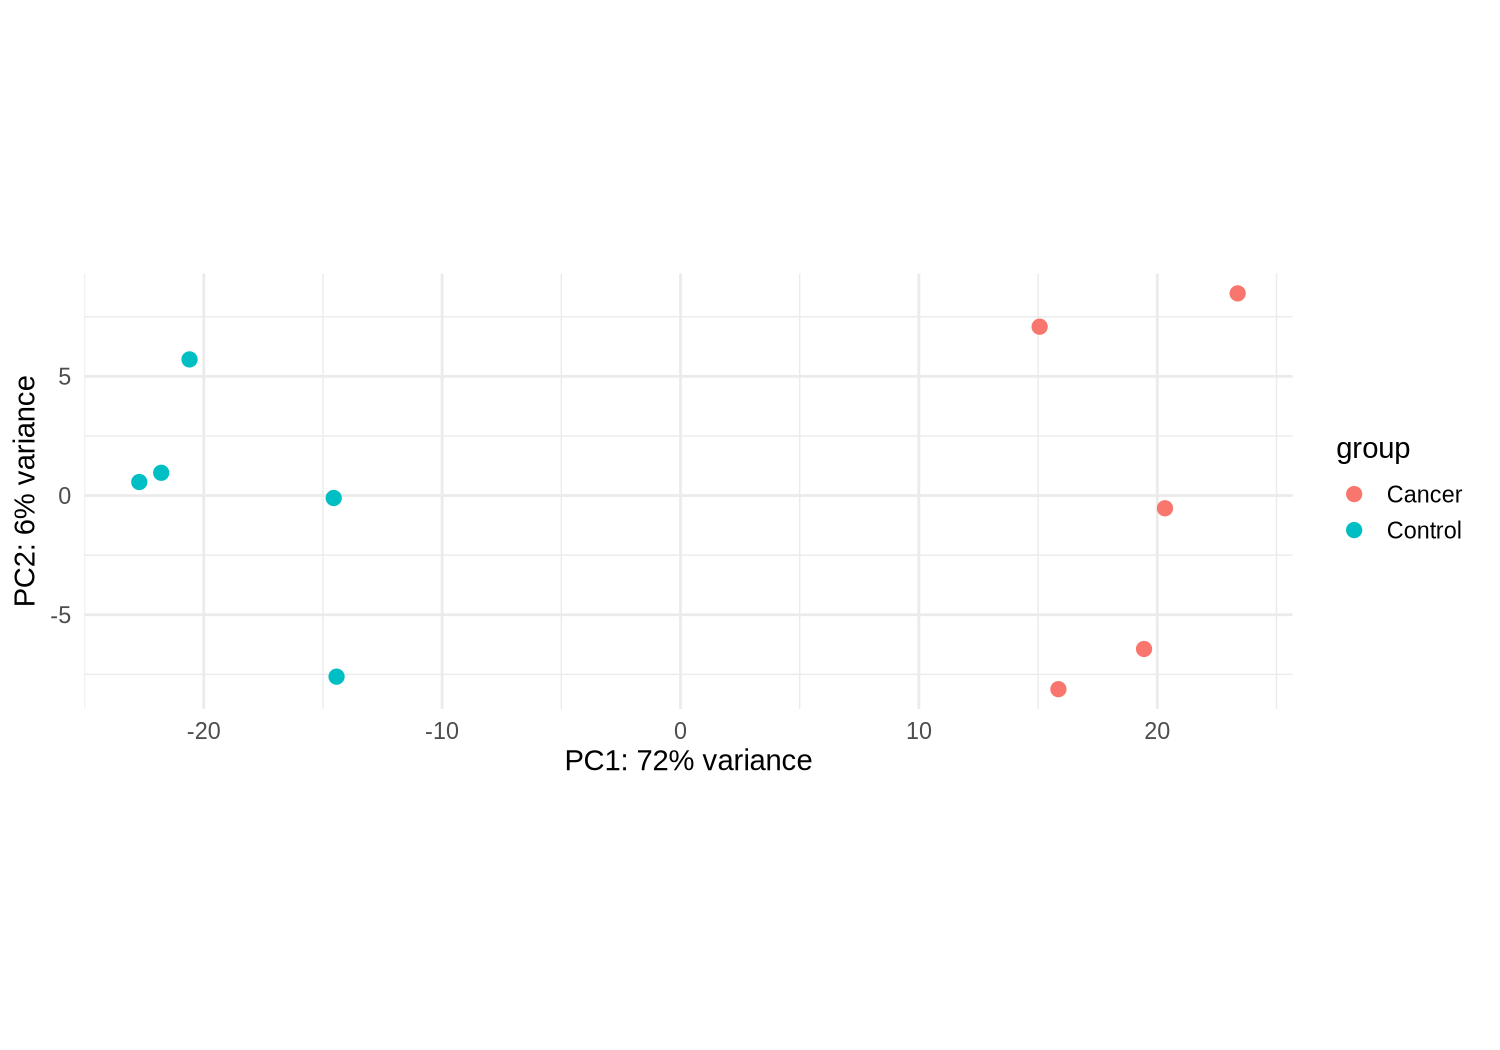

In [10]:
plotPCA(dat, intgroup="Sample_Group")

## Gene set enrichment: what are the changing pathways?

We test whether the DE genes (or ranked gene lists) are enriched for known pathways/ontologies:
- **Over-representation analysis (ORA):** use a set of significant genes as input.
- **GSEA-style (ranked):** use all genes ranked by a statistic (e.g. shrunken LFC), without picking a hard significance cutoff.

**Interpretation tips**
- Prefer **FDR**-controlled results for reporting.
- Report both **direction** (up vs down in `Sample_Group`) and **function** (pathway/GO term).
- Keep an eye on **redundant terms**; collapsing similar terms helps readability.


## Correlation-driven subclustering of genes

We can group genes by **co-expression**:
- Compute pairwise **correlations** between variance-stabilized expression profiles.
- Cluster genes based on correlation distances to find **co-expressed modules**.
- Summarize each module by its **eigengene** (first principal component of the module).

These modules often reflect shared **regulation** or **biological function**, and they are useful inputs for enrichment analyses.


## WGCNA
WGCNA groups genes into **modules** (color-labeled clusters) based on how similarly they vary across samples.

- **Inputs:** rlog/vst expression (samples × genes)
- **Output:** a color for each gene → **modules** (e.g., blue, yellow…)
- **Interpretation:** modules ≈ **gene programs**. Check their top genes and run enrichment *outside* the notebook to name the program.

**Tuning tips** (if modules are too small/noisy):
- Increase `minModuleSize` (e.g., 30–50)
- Reduce `deepSplit`
- Increase `mergeCutHeight` to merge similar modules


In [11]:
suppressMessages(library(WGCNA))

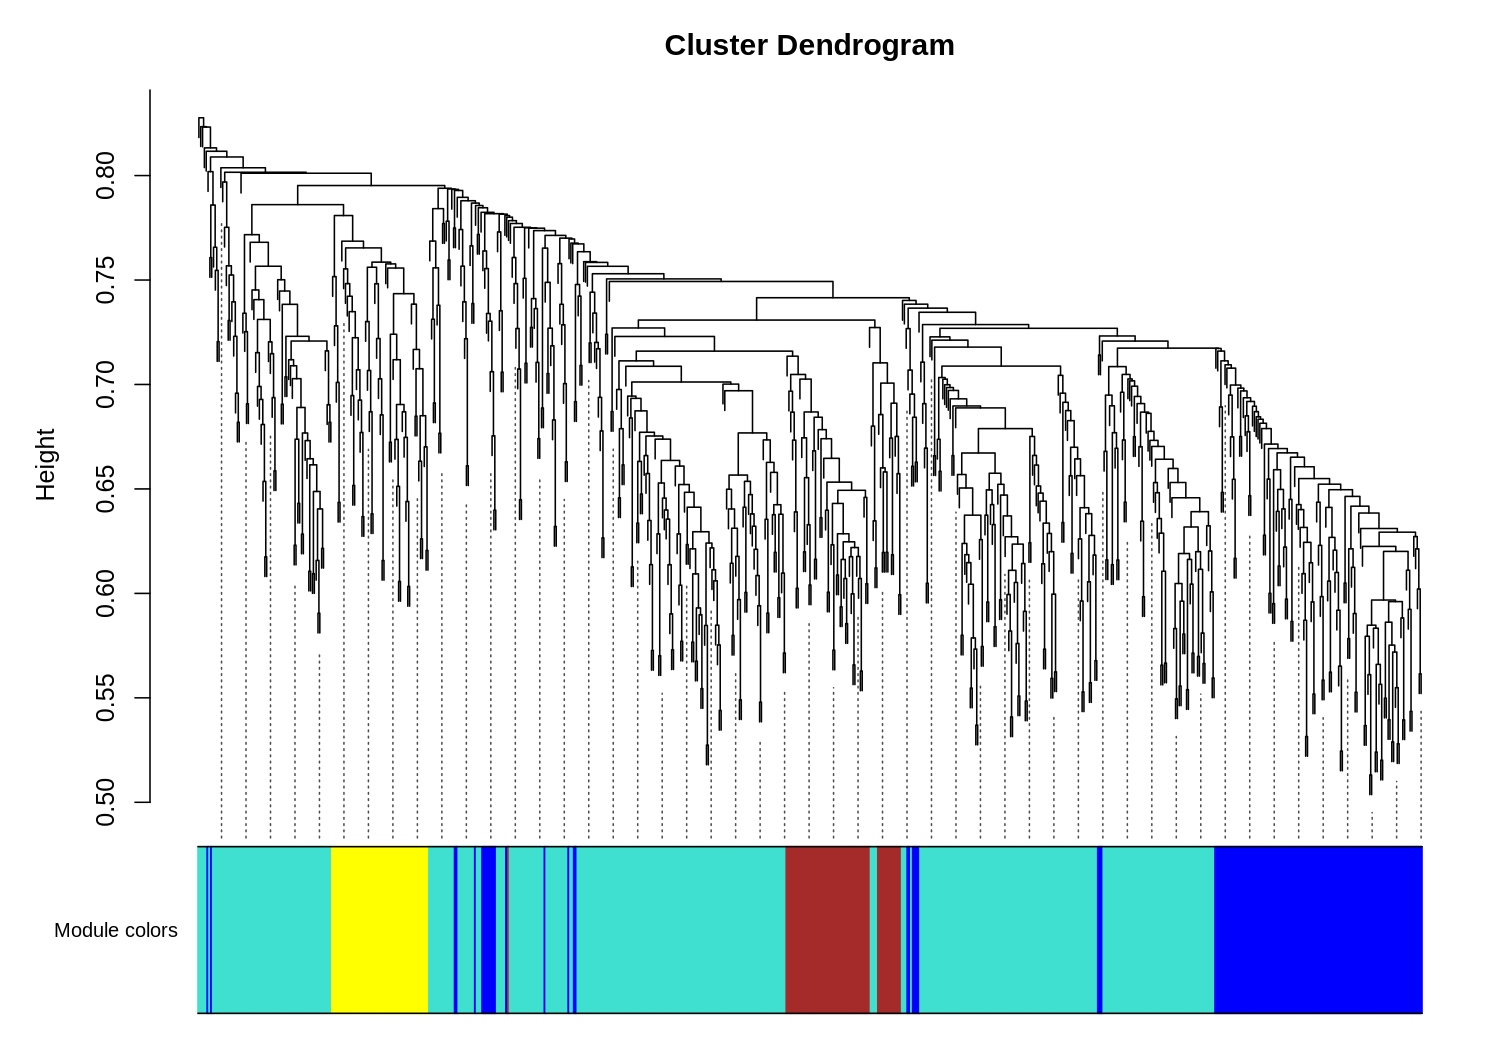

In [12]:
net <- blockwiseModules(
  t(assay(dat)),
  power = 7,
  networkType = "unsigned",
  #minModuleSize = 20,     # increase from default (e.g., 30–50)
  #deepSplit     = 1,      # 0..4; smaller → fewer modules
  #mergeCutHeight= 0.25,   # higher → merge more (default ~0.25)
   numericLabels = TRUE
)

pal <- WGCNA::standardColors(200)  # increase if needed
moduleColors <- labels2colors(net$colors, colorSeq = pal)
mColors <- moduleColors[ net$blockGenes[[1]] ]


# Example plot:
plotDendroAndColors(net$dendrograms[[1]],
                    mColors,
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)


## How to read this WGCNA dendrogram + color bar

**What you’re seeing**
- The tree (dendrogram) clusters **genes** by co-expression. Leaves (tips) are genes; nearby branches = genes with similar expression patterns across samples.
- The y-axis is a clustering **distance** (based on network similarity). Lower split height ⇒ more similar; higher ⇒ less similar.  
  *This is not fold change.*
- The horizontal **color bar** assigns each gene to a **module** (a co-expression group). A wide block of the same color = a larger module.

**What to look for**
1. **Large, continuous color blocks** → well-defined modules (gene programs).  
2. **Too many thin strips** → modules are fragmented (consider merging or increasing minimum module size).  
3. Pick 1–2 modules you find interesting and export those gene lists for **Enrichr** (outside the notebook) to name the program.

**About colors**
- Colors are just **labels/IDs** for modules. The same color anywhere in the bar means the **same module**.
- If you ever see “grey”, it usually means **unassigned** genes.
- In this notebook we used `networkType = "unsigned"`: strong **positive or negative** correlations can end up in the same module.  
  If you want modules that keep **direction** separate, use `networkType = "signed"`.

**Tuning (if modules look odd)**
- `minModuleSize` ↑  → fewer, larger modules  
- `deepSplit` ↓      → fewer modules (less aggressive splitting)  
- `mergeCutHeight` ↑ → merges similar modules more (fewer modules)

**Get the genes for a module (by color)**
```r
# Replace "blue" with a color you see in the bar
module <- "blue"

# Map each gene to a color, regardless of whether numericLabels=TRUE/FALSE
geneColors <- if (is.numeric(net$colors)) WGCNA::labels2colors(net$colors) else net$colors

genes_in_module <- names(geneColors)[geneColors == module]
head(genes_in_module)


In [13]:
#pca <- prcomp(t(assay(dat)))
#plot(pca$rotation[,1], pca$rotation[,2], pch=10, col=mColors)

In [14]:
#Now lets write the gene symbols for each cluster to a text file.
module_colors= setdiff(unique(mColors), "grey")
for (color in module_colors){
    module=model[which(mColors==color), "gene_name"]
    write.table(module, paste("module_",color, ".txt",sep=""), sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)
}

Here is an example of fetching out up/down regulated genes:

In [15]:
up <- subset(model, log2FoldChange>0)[,"gene_name"]
down <- subset(model, log2FoldChange<0)[,"gene_name"]
write.table(up,"up.txt", sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)
write.table(down,"down.txt", sep="\t", row.names=FALSE, col.names=FALSE,quote=FALSE)

# Your assignment (Notebook 2)

**Goal:** explore your DE results beyond a flat list and tell a short, coherent biological story.

## 1) Tweak parameters and observe effects
Adjust (one at a time at first):
- **Differential expression thresholds (notebook 1):**  
  - FDR (padj) — default 0.05  
  - |log2FC| — default ≥ 1
- **Heatmap size:** number of genes shown (`topN`, e.g. 30–60)
- **WGCNA / clustering:**  
  - `power` (network soft-threshold)  
  - `networkType` (`"unsigned"` vs `"signed"`)  
  - `mergeCutHeight` (module merging; higher → fewer, larger modules)  
  - (Optionally) `minModuleSize`, `deepSplit`

**Tip:** Don’t change everything at once. Note what changed and why.

## 2) What to look for
- **Heatmap:** clear separation by `Sample_Group`? Outliers? Co-expressed blocks?  
- **Modules (WGCNA or correlation clusters):** which modules track `Sample_Group`?  
  - Use module eigengenes → trait correlations.  
- **Enrichment:** run on **clusters** (and/or Up vs Down) to identify pathways/processes.

## 3) Export gene lists for Enrichr
Export **gene symbols** (one per line) for:
- **Up-regulated** (e.g., padj < 0.05, log2FC ≥ 1)
- **Down-regulated** (padj < 0.05, log2FC ≤ −1)
- **Each module** (WGCNA colors)

Upload these lists to **Enrichr** and summarize the top terms (use FDR/adjusted p).

## 4) Mini-presentation (≈ 5–10 minutes)
Prepare 3–5 slides:
1. **What you changed** (parameters + 1–2 sentences why)
2. **Key figure(s)**: can be from notebook, or from an enrichment online tool or anything else
3. **Enrichment highlights**: top terms for one cluster (or Up vs Down)
4. **Biological interpretation**: a couple of sentences tying terms → biology
5. **Limitations / next step**: e.g., batch, small n, lenient thresholds

## Grading / “what good looks like”
- Uses **FDR + effect size** thresholds consistently
- Shows **structure** (genelists) and **function** (enrichment)
- Interprets signs (which group is higher) correctly
- Clear, reproducible steps (state the parameters you used)
